Tafel Slope: 968.562 mV/decade
Exchange Current Density (j0): 58.91 A/cm²


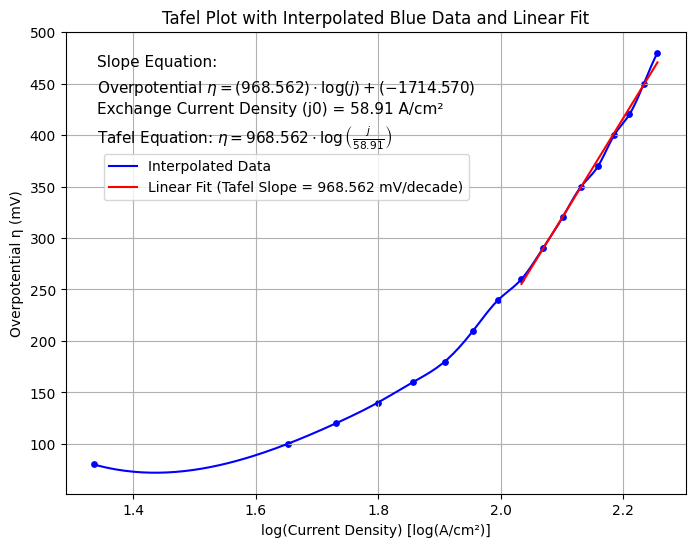

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.interpolate import make_interp_spline

# Load the Excel file (update the path if necessary)
file_path = 'C:\\Users\\User\\Desktop\\Internship\\Real Results\\Book1.xlsx'
df = pd.read_excel(file_path)

# Rename columns for easier access (update if necessary)
df.columns = [
    'Power_Level', 'Voltage', 'Current', 'Surface_Area', 'Hydrogen_Volume_Flow',
    'Valve_Output', 'Temperature', 'Pressure', 'Voltage_Cell', 'Current_Density', 
    'Current_Cell', 'Real_Hydrogen_Volume_Flow_m3', 'Real_Hydrogen_Volume_Flow_kg', 
    'Mass_Flow_kg_s', 'Hydrogen_Mol_Flow', 'Voltage_Efficiency', 'Faraday_Efficiency', 
    'Cell_Efficiency', 'Power', 'Overall_Efficiency'
]

# Drop the first row if it contains units (adjust as needed)
df = df.drop(0)

# Ensure relevant columns are numeric (ignore errors for non-numeric cells)
df['Voltage_Cell'] = pd.to_numeric(df['Voltage_Cell'], errors='coerce')
df['Current_Density'] = pd.to_numeric(df['Current_Density'], errors='coerce')

# Drop rows with missing values in the columns of interest
df = df.dropna(subset=['Voltage_Cell', 'Current_Density'])

# Calculate overpotential (η) in millivolts (mV)
E0 = 1.23  # Standard potential for hydrogen evolution reaction in V
df['Overpotential'] = (df['Voltage_Cell'] - E0) * 1000  # Convert overpotential to mV (η = (E - E0) * 1000)

# Select data for Tafel plot: Overpotential (η) vs log(Current Density)
current_density = df['Current_Density']
overpotential = df['Overpotential']

# Convert current density to log scale (only positive values)
log_current_density = np.log10(current_density[current_density > 0])
overpotential = overpotential[current_density > 0]

# Interpolate blue data points for smooth curve
log_current_density_smooth = np.linspace(log_current_density.min(), log_current_density.max(), 200)
overpotential_smooth = make_interp_spline(log_current_density, overpotential)(log_current_density_smooth)

# Plot the original data and interpolated blue line
plt.figure(figsize=(8, 6))
plt.scatter(log_current_density, overpotential, color='blue', s=15)  # Adjusted size of dots
plt.plot(log_current_density_smooth, overpotential_smooth, color='blue', linestyle='-', label='Interpolated Data')

# Define a linear region and perform linear regression for Tafel slope
linear_region = (log_current_density > 2) & (log_current_density < 2.3)  # Adjust based on data

if log_current_density[linear_region].empty or overpotential[linear_region].empty:
    print("Warning: No data points in the selected linear region. Adjust the range.")
else:
    # Perform linear regression on the selected linear region
    slope, intercept, r_value, p_value, std_err = linregress(
        log_current_density[linear_region], overpotential[linear_region]
    )
    print(f'Tafel Slope: {slope:.3f} mV/decade')

    # Generate smooth values for the linear fit
    log_current_density_fit = np.linspace(log_current_density[linear_region].min(), log_current_density[linear_region].max(), 100)
    overpotential_fit = intercept + slope * log_current_density_fit

    # Plot the Tafel fit line (red) on top of interpolated blue data
    plt.plot(log_current_density_fit, overpotential_fit, color='red', label=f'Linear Fit (Tafel Slope = {slope:.3f} mV/decade)')

    # Calculate the x-intercept (exchange current density) and format it in decimal
    j0 = 10 ** (-intercept / slope)  # j0 = 10^(-c/m)
    j0_formatted = f"{j0:.2f}"  # Format as a decimal with two decimal places
    print(f'Exchange Current Density (j0): {j0_formatted} A/cm²')

    # Display the slope equation, Tafel equation, and formatted exchange current density
    slope_equation_text = f'Overpotential $\eta = ({slope:.3f}) \cdot \log(j) + ({intercept:.3f})$'
    context_text = 'Slope Equation:'
    x_intercept_text = f'Exchange Current Density (j0) = {j0_formatted} A/cm²'
    tafel_equation_text = rf'Tafel Equation: $\eta = {slope:.3f} \cdot \log \left( \frac{{j}}{{{j0_formatted}}} \right)$'

    # Adjust the font size for each label (example: fontsize=10)
    plt.text(0.05, 0.95, context_text, transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.text(0.05, 0.90, slope_equation_text, transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.text(0.05, 0.85, x_intercept_text, transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.text(0.05, 0.80, tafel_equation_text, transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', horizontalalignment='left')
    
    # Move the legend position to below the equations
    plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.75), fontsize=10)

# Customize plot
plt.xlabel('log(Current Density) [log(A/cm²)]')
plt.ylabel('Overpotential η (mV)')
plt.title('Tafel Plot with Interpolated Blue Data and Linear Fit')
plt.grid(True)
plt.show()
